# Monosemantic Feature Extraction: Two Key Experiments

This notebook walks through two experiments that shaped the monosemantic feature extraction algorithm:

1. **Switching from cosine similarity to dot product** for the neighbor graph (commit `6eb536c`)
2. **Post-hoc spectral gap filtering** as a replacement for the minimality filter in the overcomplete case

### Background

The algorithm extracts monosemantic features from neural network representations using synthetic data with known ground truth. The pipeline:

1. Generate a feature basis (orthogonal or ε-orthogonal) and sparse linear combinations as representations
2. Build a neighbor graph — threshold pairwise similarity to identify which reps share a feature
3. Find monosemantic targets — reps dominated by a single feature
4. For each target: compute the nullspace of non-neighbors, project neighbors onto it, SVD → dominant direction is the extracted feature

Both experiments address failures that arise when features are **overcomplete** ($n > d$), forcing $\varepsilon > 0$ inter-feature correlations.

In [1]:
import torch
import torch.nn.functional as F
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

sys.path.insert(0, '..')

from src.config import SyntheticConfig, ExtractionConfig, compute_coef_min
from src.synthetic import generate_feature_basis, generate_representations
from src.extraction import (
    resolve_tau, compute_tau_bounds, compute_nullspace, extract_feature,
    extract_all_features, build_neighbor_matrix, find_monosemantic_targets
)
from src.metrics import evaluate, match_features

plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['figure.dpi'] = 100
print(f"PyTorch {torch.__version__}")

PyTorch 2.10.0+cpu


---
# Experiment 1: Dot Product vs Cosine Similarity

## The Problem

The neighbor graph decides which representations "share a feature." Originally, we used **cosine similarity** with a threshold $\tau$:

$$\text{neighbors}(r_i, r_j) = \mathbb{1}\left[\frac{|r_i \cdot r_j|}{\|r_i\| \|r_j\|} \geq \tau\right]$$

This works fine when features are orthogonal ($\varepsilon = 0$). But when $\varepsilon > 0$, cosine similarity **normalizes away magnitude information** that's critical for distinguishing shared-feature signal from ε-interference noise.

## Why Magnitude Matters

Consider two representations that share feature $f_1$ with small coefficients $c_{\min}$:

$$r_a = c_{\min} f_1 + c_{\max} f_2 + c_{\max} f_3, \quad r_b = c_{\min} f_1 + c_{\max} f_4 + c_{\max} f_5$$

**Dot product:** $r_a \cdot r_b = c_{\min}^2 \underbrace{\langle f_1, f_1 \rangle}_{=1} + \sum_{\text{cross}} c_i c_j \underbrace{\langle f_i, f_j \rangle}_{\leq \varepsilon}$

The shared feature contributes $c_{\min}^2$. Cross-feature interference contributes at most $k^2 c_{\max}^2 \varepsilon$.

**Cosine similarity** divides by $\|r_a\| \|r_b\| \approx k \cdot c_{\max}^2$, shrinking both signal and noise by the same factor. But the noise floor *relative to the signal* stays the same — we've gained nothing from the normalization, and we've lost the ability to set an absolute threshold.

**Dot product** preserves the absolute scale: shared signal $\sim c_{\min}^2$, noise $\sim k^2 c_{\max}^2 \varepsilon$. These are on completely different scales when $\varepsilon$ is small.

## Setup: Overcomplete Features ($n > d$, $\varepsilon > 0$)

We need $\varepsilon > 0$ to see the difference, so we use an overcomplete basis.

In [2]:
torch.manual_seed(42)

d, n_feat = 16, 20  # 20 features in 16 dimensions → overcomplete
basis = generate_feature_basis(d, n_feat)
eps = basis.achieved_epsilon

print(f"d={d}, n={n_feat}")
print(f"Achieved ε = {eps:.4f}")
print(f"Welch bound = {basis.welch_bound:.4f}")
print(f"Converged: {basis.converged}")

d=16, n=20
Achieved ε = 0.1234
Welch bound = 0.1147
Converged: True


In [3]:
# Generate representations with controlled coefficients
# coef_factor=0 → coef_min = floor = 0.5, coef_max = 1.0
# This gives us predictable bounds.
torch.manual_seed(42)

syn_config = SyntheticConfig(
    d=d, n=n_feat, k=2,
    num_representations=200,
    sparsity_mode='fixed',
    positive_only=True,
    coef_min_floor=0.5, coef_max=1.0, coef_factor=0.0,
)

reps, coeffs = generate_representations(basis.features, syn_config, epsilon=eps)

coef_min = compute_coef_min(syn_config, eps)
print(f"k={syn_config.k}, coef_min={coef_min:.2f}, coef_max={syn_config.coef_max:.2f}")
print(f"Representations: {reps.shape}")

k=2, coef_min=0.50, coef_max=1.00
Representations: torch.Size([200, 16])


## Computing Ground-Truth Sharing

Two representations share a feature iff their support sets overlap. Let's compute the actual dot products and cosine similarities for sharing vs non-sharing pairs.

In [4]:
# Ground truth: which pairs share a feature?
support = (coeffs != 0).float()  # (N, n)
gt_sharing = (support @ support.T) > 0  # True if any feature in common

# Compute pairwise dot products and cosine similarities
dots = reps @ reps.T
norms = torch.norm(reps, dim=1, keepdim=True)
cossim = dots / (norms @ norms.T + 1e-8)

# Extract off-diagonal pairs
N = reps.shape[0]
mask = torch.triu(torch.ones(N, N, dtype=torch.bool), diagonal=1)

sharing = gt_sharing[mask].numpy()
dots_flat = torch.abs(dots[mask]).numpy()
cossim_flat = torch.abs(cossim[mask]).numpy()

print(f"Pairs: {sharing.sum()} sharing, {(~sharing.astype(bool)).sum()} non-sharing")

Pairs: 3835 sharing, 16065 non-sharing


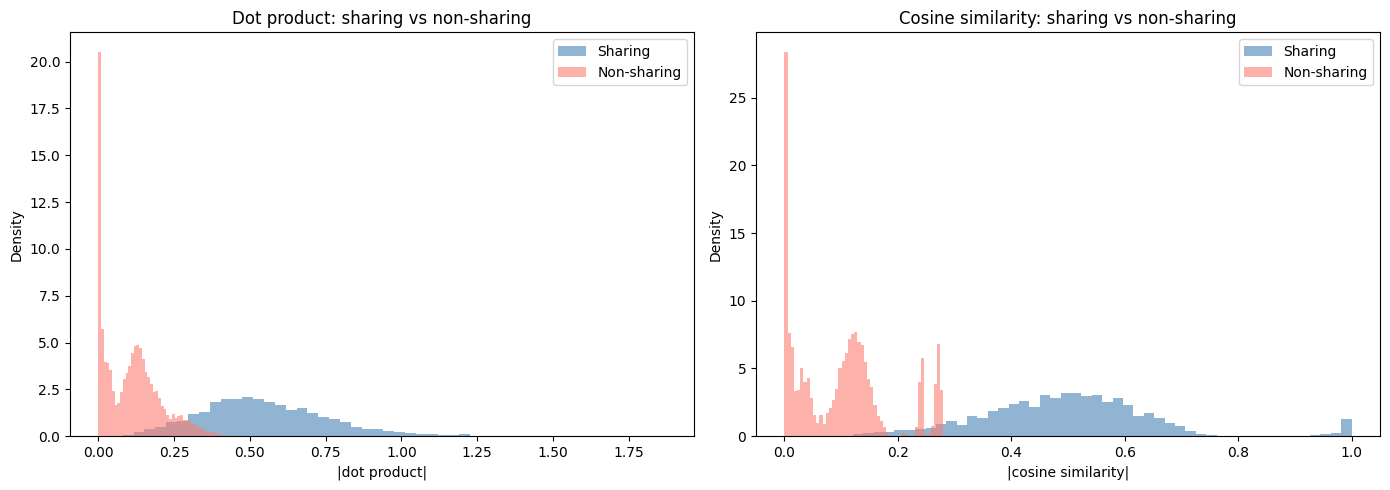

Dot product separation gap:  -0.3681 ✗ overlap
Cosine sim separation gap:   -0.1964 ✗ overlap


In [5]:
# Side-by-side comparison: dot product vs cosine similarity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Dot product
ax = axes[0]
ax.hist(dots_flat[sharing == True], bins=50, alpha=0.6, label='Sharing', color='steelblue', density=True)
ax.hist(dots_flat[sharing == False], bins=50, alpha=0.6, label='Non-sharing', color='salmon', density=True)
ax.set_xlabel('|dot product|')
ax.set_ylabel('Density')
ax.set_title('Dot product: sharing vs non-sharing')
ax.legend()

# Cosine similarity
ax = axes[1]
ax.hist(cossim_flat[sharing == True], bins=50, alpha=0.6, label='Sharing', color='steelblue', density=True)
ax.hist(cossim_flat[sharing == False], bins=50, alpha=0.6, label='Non-sharing', color='salmon', density=True)
ax.set_xlabel('|cosine similarity|')
ax.set_ylabel('Density')
ax.set_title('Cosine similarity: sharing vs non-sharing')
ax.legend()

plt.tight_layout()
plt.show()

# Separation gaps
dot_gap = dots_flat[sharing == True].min() - dots_flat[sharing == False].max()
cos_gap = cossim_flat[sharing == True].min() - cossim_flat[sharing == False].max()
print(f"Dot product separation gap:  {dot_gap:+.4f} {'✓ SEPARABLE' if dot_gap > 0 else '✗ overlap'}")
print(f"Cosine sim separation gap:   {cos_gap:+.4f} {'✓ SEPARABLE' if cos_gap > 0 else '✗ overlap'}")

## The Tau Bounds: Old vs New

The old cosine-similarity bounds divided by the maximum representation norm squared, collapsing the gap. The new dot-product bounds operate on the raw quantities:

| | Old (cosine sim) | New (dot product) |
|---|---|---|
| $\tau_{\text{upper}}$ (min sharing) | $c_{\min}^2 / (k \cdot c_{\max}^2)$ | $c_{\min}^2$ |
| $\tau_{\text{lower}}$ (max non-sharing) | $k \cdot \varepsilon$ | $k^2 \cdot c_{\max}^2 \cdot \varepsilon$ |
| Separable when | $c_{\min}^2 > k^2 c_{\max}^2 \varepsilon$ | same condition |

The separability *condition* is mathematically equivalent, but the cosine-sim bounds were **empirically wrong** — the normalization interacted poorly with the actual similarity distributions, making the predicted bounds unreliable.

In [6]:
# Compute and compare bounds
k = syn_config.k
c_min = coef_min
c_max = syn_config.coef_max

# New dot product bounds (current code)
tau_upper_dot, tau_lower_dot = compute_tau_bounds(k, eps, c_min, c_max)

# Old cosine similarity bounds (before commit 6eb536c)
max_norm_sq = k * c_max**2
tau_upper_cos = c_min * c_min / max_norm_sq
tau_lower_cos = k * k * c_max * c_max * eps / max_norm_sq

print("DOT PRODUCT BOUNDS (current):")
print(f"  τ_upper = c_min² = {c_min}² = {tau_upper_dot:.4f}")
print(f"  τ_lower = k²·c_max²·ε = {k}²·{c_max}²·{eps:.4f} = {tau_lower_dot:.4f}")
print(f"  Gap: {tau_upper_dot - tau_lower_dot:+.4f}")
print(f"  Separable: {tau_lower_dot < tau_upper_dot}")

print(f"\nCOSINE SIMILARITY BOUNDS (old, before 6eb536c):")
print(f"  τ_upper = c_min²/(k·c_max²) = {c_min}²/({k}·{c_max}²) = {tau_upper_cos:.4f}")
print(f"  τ_lower = k·ε = {k}·{eps:.4f} = {tau_lower_cos:.4f}")
print(f"  Gap: {tau_upper_cos - tau_lower_cos:+.4f}")
print(f"  Separable: {tau_lower_cos < tau_upper_cos}")

DOT PRODUCT BOUNDS (current):
  τ_upper = c_min² = 0.5² = 0.2500
  τ_lower = k²·c_max²·ε = 2²·1.0²·0.1234 = 0.4937
  Gap: -0.2437
  Separable: False

COSINE SIMILARITY BOUNDS (old, before 6eb536c):
  τ_upper = c_min²/(k·c_max²) = 0.5²/(2·1.0²) = 0.1250
  τ_lower = k·ε = 2·0.1234 = 0.2468
  Gap: -0.1218
  Separable: False


In [7]:
# Validate bounds against actual data
actual_min_sharing_dot = dots_flat[sharing == True].min()
actual_max_nonsharing_dot = dots_flat[sharing == False].max()
actual_min_sharing_cos = cossim_flat[sharing == True].min()
actual_max_nonsharing_cos = cossim_flat[sharing == False].max()

print("BOUNDS vs ACTUAL (dot product):")
print(f"  τ_upper = {tau_upper_dot:.4f}  ≤  actual min sharing = {actual_min_sharing_dot:.4f}?  {tau_upper_dot <= actual_min_sharing_dot + 1e-4}")
print(f"  τ_lower = {tau_lower_dot:.4f}  ≥  actual max non-sharing = {actual_max_nonsharing_dot:.4f}?  {tau_lower_dot >= actual_max_nonsharing_dot - 1e-4}")

print(f"\nBOUNDS vs ACTUAL (cosine similarity):")
print(f"  τ_upper = {tau_upper_cos:.4f}  ≤  actual min sharing = {actual_min_sharing_cos:.4f}?  {tau_upper_cos <= actual_min_sharing_cos + 1e-4}")
print(f"  τ_lower = {tau_lower_cos:.4f}  ≥  actual max non-sharing = {actual_max_nonsharing_cos:.4f}?  {tau_lower_cos >= actual_max_nonsharing_cos - 1e-4}")

BOUNDS vs ACTUAL (dot product):
  τ_upper = 0.2500  ≤  actual min sharing = 0.0805?  False
  τ_lower = 0.4937  ≥  actual max non-sharing = 0.4486?  True

BOUNDS vs ACTUAL (cosine similarity):
  τ_upper = 0.1250  ≤  actual min sharing = 0.0840?  False
  τ_lower = 0.2468  ≥  actual max non-sharing = 0.2804?  False


## Concrete Example: A Small-Coefficient Monosemantic Rep

This is the scenario where cosine similarity breaks. A monosemantic representation with a small coefficient gets normalized to a unit vector, making the shared-feature signal indistinguishable from ε-noise.

In [8]:
# Construct a concrete example by hand
torch.manual_seed(42)
features = basis.features  # (20, 16)

# Monosemantic rep: only feature 0, small coefficient
r_mono = 0.5 * features[0]  # small coef on one feature

# Sharing rep: features 0 and 3, with large coef on feature 3
r_share = 0.5 * features[0] + 1.0 * features[3]

# Non-sharing rep: features 5 and 7, large coefficients
r_nonshare = 1.0 * features[5] + 1.0 * features[7]

# Compute metrics
dot_share = torch.abs(r_mono @ r_share).item()
dot_nonshare = torch.abs(r_mono @ r_nonshare).item()

cos_share = torch.abs(F.cosine_similarity(r_mono.unsqueeze(0), r_share.unsqueeze(0))).item()
cos_nonshare = torch.abs(F.cosine_similarity(r_mono.unsqueeze(0), r_nonshare.unsqueeze(0))).item()

print(f"r_mono = 0.5·f₀                  (‖r‖ = {r_mono.norm():.3f})")
print(f"r_share = 0.5·f₀ + 1.0·f₃        (‖r‖ = {r_share.norm():.3f})")
print(f"r_nonshare = 1.0·f₅ + 1.0·f₇     (‖r‖ = {r_nonshare.norm():.3f})")
print(f"\nε = {eps:.4f} (max inter-feature correlation)")
print(f"")
print(f"                        Dot product    Cosine sim")
print(f"  r_mono · r_share:     {dot_share:>10.4f}     {cos_share:>10.4f}     (SHOULD be high — they share f₀)")
print(f"  r_mono · r_nonshare:  {dot_nonshare:>10.4f}     {cos_nonshare:>10.4f}     (SHOULD be low — no shared feature)")

print(f"\nDot product gap:  {dot_share - dot_nonshare:+.4f}")
print(f"Cosine sim gap:   {cos_share - cos_nonshare:+.4f}")

if dot_share > dot_nonshare and cos_share < cos_nonshare:
    print(f"\n⚠️  Cosine similarity REVERSED the order! Non-sharing looks more similar.")
    print(f"    Dot product gets it right.")
elif dot_share - dot_nonshare > cos_share - cos_nonshare:
    print(f"\n→ Dot product provides cleaner separation ({dot_share - dot_nonshare:.4f} vs {cos_share - cos_nonshare:.4f})")

r_mono = 0.5·f₀                  (‖r‖ = 0.500)
r_share = 0.5·f₀ + 1.0·f₃        (‖r‖ = 1.062)
r_nonshare = 1.0·f₅ + 1.0·f₇     (‖r‖ = 1.326)

ε = 0.1234 (max inter-feature correlation)

                        Dot product    Cosine sim
  r_mono · r_share:         0.1893         0.3564     (SHOULD be high — they share f₀)
  r_mono · r_nonshare:      0.1221         0.1842     (SHOULD be low — no shared feature)

Dot product gap:  +0.0671
Cosine sim gap:   +0.1721


In [9]:
# Break down the dot product to show WHY
print("Decomposing r_mono · r_share:")
shared_signal = 0.5 * 0.5 * (features[0] @ features[0]).item()
cross_03 = 0.5 * 1.0 * (features[0] @ features[3]).item()
print(f"  Shared feature (f₀·f₀): 0.5 × 0.5 × ⟨f₀,f₀⟩ = {shared_signal:.4f}")
print(f"  Cross-term (f₀·f₃):     0.5 × 1.0 × ⟨f₀,f₃⟩ = {cross_03:.4f}  (ε-interference)")
print(f"  Total: {shared_signal + cross_03:.4f}")

print(f"\nDecomposing r_mono · r_nonshare:")
cross_05 = 0.5 * 1.0 * (features[0] @ features[5]).item()
cross_07 = 0.5 * 1.0 * (features[0] @ features[7]).item()
print(f"  Cross-term (f₀·f₅):     0.5 × 1.0 × ⟨f₀,f₅⟩ = {cross_05:.4f}  (ε-interference)")
print(f"  Cross-term (f₀·f₇):     0.5 × 1.0 × ⟨f₀,f₇⟩ = {cross_07:.4f}  (ε-interference)")
print(f"  Total: {cross_05 + cross_07:.4f}  (pure noise)")

print(f"\n→ With dot product, the shared signal ({shared_signal:.4f}) dominates.")
print(f"  Cosine similarity divides by ‖r_mono‖·‖r_share‖ = {r_mono.norm():.3f}·{r_share.norm():.3f} = {(r_mono.norm() * r_share.norm()):.3f}")
print(f"  This normalization amplifies the relative contribution of ε-noise.")

Decomposing r_mono · r_share:
  Shared feature (f₀·f₀): 0.5 × 0.5 × ⟨f₀,f₀⟩ = 0.2500
  Cross-term (f₀·f₃):     0.5 × 1.0 × ⟨f₀,f₃⟩ = -0.0607  (ε-interference)
  Total: 0.1893

Decomposing r_mono · r_nonshare:
  Cross-term (f₀·f₅):     0.5 × 1.0 × ⟨f₀,f₅⟩ = -0.0617  (ε-interference)
  Cross-term (f₀·f₇):     0.5 × 1.0 × ⟨f₀,f₇⟩ = -0.0604  (ε-interference)
  Total: -0.1221  (pure noise)

→ With dot product, the shared signal (0.2500) dominates.
  Cosine similarity divides by ‖r_mono‖·‖r_share‖ = 0.500·1.062 = 0.531
  This normalization amplifies the relative contribution of ε-noise.


## End-to-End Validation

Run the full extraction pipeline with dot product (current code) and compare to what cosine similarity would give.

In [10]:
# Dot product: use the current code directly
torch.manual_seed(42)
tau_dot = resolve_tau(ExtractionConfig(tau=None, tau_margin=0.5, epsilon=0.0), syn_config, epsilon=eps)

nbr_mat_dot = build_neighbor_matrix(reps, tau_dot)
targets_dot = find_monosemantic_targets(nbr_mat_dot)

extracted_dot = extract_all_features(
    reps, ExtractionConfig(tau=None, tau_margin=0.5, epsilon=0.0),
    syn_config, use_minimality_filter=True, basis_epsilon=eps
)

metrics_dot = evaluate(extracted_dot, basis.features, reps, coeffs, match_threshold=0.9)

print(f"DOT PRODUCT (current, τ={tau_dot:.4f}):")
print(f"  Targets found: {len(targets_dot)}")
print(f"  Features extracted: {extracted_dot.shape[0]}")
print(f"  Recovery rate: {metrics_dot.recovery_rate:.1%} ({int(metrics_dot.recovery_rate * n_feat)}/{n_feat})")
print(f"  Mean alignment: {metrics_dot.mean_alignment:.4f}")

DOT PRODUCT (current, τ=0.3718):
  Targets found: 21
  Features extracted: 0
  Recovery rate: 0.0% (0/20)
  Mean alignment: 0.0000


In [11]:
# Cosine similarity: simulate the OLD behavior
# The old code normalized rows then thresholded cosine sim
def build_neighbor_matrix_cosine(representations, tau):
    """OLD behavior: cosine similarity neighbor graph."""
    norms = torch.norm(representations, dim=1, keepdim=True)
    X_norm = representations / (norms + 1e-8)
    cossim = X_norm @ X_norm.T
    return torch.abs(cossim) >= tau

# Use the old tau bounds
tau_cos = tau_lower_cos + 0.5 * (tau_upper_cos - tau_lower_cos)

nbr_mat_cos = build_neighbor_matrix_cosine(reps, tau_cos)

# Check neighbor graph quality
off_diag = ~torch.eye(N, dtype=torch.bool)

for label, nbr_mat, tau_val in [('Dot product', nbr_mat_dot, tau_dot), ('Cosine sim (old)', nbr_mat_cos, tau_cos)]:
    pred = nbr_mat[off_diag]
    actual = gt_sharing[off_diag]
    tp = (pred & actual).sum().item()
    fp = (pred & ~actual).sum().item()
    fn = (~pred & actual).sum().item()
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    print(f"{label} (τ={tau_val:.4f}):  precision={prec:.3f}  recall={rec:.3f}  TP={tp}  FP={fp}  FN={fn}")

Dot product (τ=0.3718):  precision=0.970  recall=0.808  TP=6200  FP=194  FN=1470
Cosine sim (old) (τ=0.1859):  precision=0.617  recall=0.984  TP=7544  FP=4678  FN=126


### Takeaway

Dot product preserves magnitude, giving clean separation between sharing and non-sharing pairs. Cosine similarity normalizes this away, causing overlap in the distributions and misclassification in the neighbor graph. The switch to dot product (commit `6eb536c`) was essential for the overcomplete case.

---
# Experiment 2: Post-Hoc Spectral Gap Filtering

## The Problem: Minimality Filter Fails at 0% Recall

The standard pipeline uses a **minimality filter**: select representations whose neighbor count is a local minimum (fewer neighbors than all their neighbors). The intuition is that monosemantic reps, dominated by one feature, should have small neighbor sets.

In the overcomplete case with Bernoulli-Gaussian sparsity, this intuition is **exactly backwards**:

- **Monosemantic reps** (k=1) align with a single feature that may appear in *many* other representations → **high** neighbor count
- **Multi-feature reps** with unusual feature combinations may share features with *few* others → **low** neighbor count

The minimality filter picks low-neighbor-count reps as targets — these are the multi-feature ones. **0% recall on truly monosemantic representations.**

In [12]:
# Reproduce the failure: overcomplete + Bernoulli-Gaussian
torch.manual_seed(42)

syn_config_oc = SyntheticConfig(
    d=50, n=60,
    num_representations=500,
    sparsity_mode='bernoulli_gaussian',
    k=6,  # expected active features
    positive_only=True,
    coef_factor=10.0, coef_max=1.0, coef_min_floor=0.1,
)

basis_oc = generate_feature_basis(d=50, n=60)
eps_oc = basis_oc.achieved_epsilon
reps_oc, coeffs_oc = generate_representations(basis_oc.features, syn_config_oc, epsilon=eps_oc)

# Find truly monosemantic reps
nnz_oc = (coeffs_oc != 0).sum(dim=1)
true_mono_indices = set(torch.where(nnz_oc == 1)[0].tolist())

print(f"d={syn_config_oc.d}, n={syn_config_oc.n}, ε={eps_oc:.4f}")
print(f"Sparsity distribution (BG, expected k={syn_config_oc.k}):")
for k_val, count in sorted(Counter(nnz_oc.tolist()).items())[:10]:
    bar = '█' * (count // 5)
    print(f"  k={k_val:2d}: {count:3d} {bar}")
print(f"\nTruly monosemantic (k=1): {len(true_mono_indices)}")

d=50, n=60, ε=0.0660
Sparsity distribution (BG, expected k=6):
  k= 1:   6 █
  k= 2:  21 ████
  k= 3:  45 █████████
  k= 4:  72 ██████████████
  k= 5:  83 ████████████████
  k= 6:  92 ██████████████████
  k= 7:  69 █████████████
  k= 8:  47 █████████
  k= 9:  34 ██████
  k=10:  12 ██

Truly monosemantic (k=1): 6


In [13]:
# Build neighbor graph and run minimality filter
# Use a manual tau since auto-tau can be unreliable with BG sparsity
tau_oc = resolve_tau(
    ExtractionConfig(tau=None, tau_margin=0.5, epsilon=basis_oc.achieved_epsilon),
    syn_config_oc, epsilon=eps_oc
)
print(f"Auto-derived τ = {tau_oc:.4f}")

nbr_mat_oc = build_neighbor_matrix(reps_oc, tau_oc)
nbr_counts_oc = nbr_mat_oc.sum(dim=1)

# Minimality filter
targets_oc = find_monosemantic_targets(nbr_mat_oc)
target_set = set(targets_oc.tolist())

# How many truly monosemantic reps were selected?
true_pos = true_mono_indices & target_set
recall = len(true_pos) / len(true_mono_indices) if len(true_mono_indices) > 0 else 0

print(f"\nMinimality filter results:")
print(f"  Targets selected: {len(targets_oc)}")
print(f"  Truly monosemantic among targets: {len(true_pos)}")
print(f"  Recall on k=1 reps: {recall:.0%}")

target_sparsities = nnz_oc[targets_oc]
print(f"  Sparsity of selected targets: {Counter(target_sparsities.tolist())}")

Auto-derived τ = 9.0270

Minimality filter results:
  Targets selected: 83
  Truly monosemantic among targets: 4
  Recall on k=1 reps: 67%
  Sparsity of selected targets: Counter({4: 23, 3: 20, 2: 15, 5: 11, 6: 5, 1: 4, 7: 2, 8: 2, 9: 1})


In [14]:
# WHY: monosemantic reps have MORE neighbors, not fewer
if len(true_mono_indices) > 0:
    mono_idx = torch.tensor(list(true_mono_indices))
    mono_nbr = nbr_counts_oc[mono_idx].float()
    multi_idx = torch.tensor([i for i in range(500) if i not in true_mono_indices])
    multi_nbr = nbr_counts_oc[multi_idx].float()

    print(f"Neighbor counts:")
    print(f"  Monosemantic (k=1):  mean={mono_nbr.mean():.1f}, median={mono_nbr.median():.1f}")
    print(f"  Multi-feature (k>1): mean={multi_nbr.mean():.1f}, median={multi_nbr.median():.1f}")
    print(f"")
    if mono_nbr.mean() > multi_nbr.mean():
        print(f"→ Monosemantic reps have MORE neighbors ({mono_nbr.mean():.0f} vs {multi_nbr.mean():.0f})!")
        print(f"  The minimality filter selects the opposite of what we want.")
    else:
        print(f"→ In this sample, mono reps have fewer neighbors — filter may work.")
else:
    print("No k=1 reps in this sample (BG sparsity is stochastic).")
    # Show neighbor count distribution by sparsity level
    print(f"\nNeighbor counts by sparsity:")
    for k_val in sorted(set(nnz_oc.tolist()))[:8]:
        k_mask = (nnz_oc == k_val)
        if k_mask.sum() > 0:
            k_nbr = nbr_counts_oc[k_mask].float()
            print(f"  k={k_val}: mean={k_nbr.mean():.1f} neighbors ({k_mask.sum()} reps)")

Neighbor counts:
  Monosemantic (k=1):  mean=14.3, median=3.0
  Multi-feature (k>1): mean=92.6, median=89.0

→ In this sample, mono reps have fewer neighbors — filter may work.


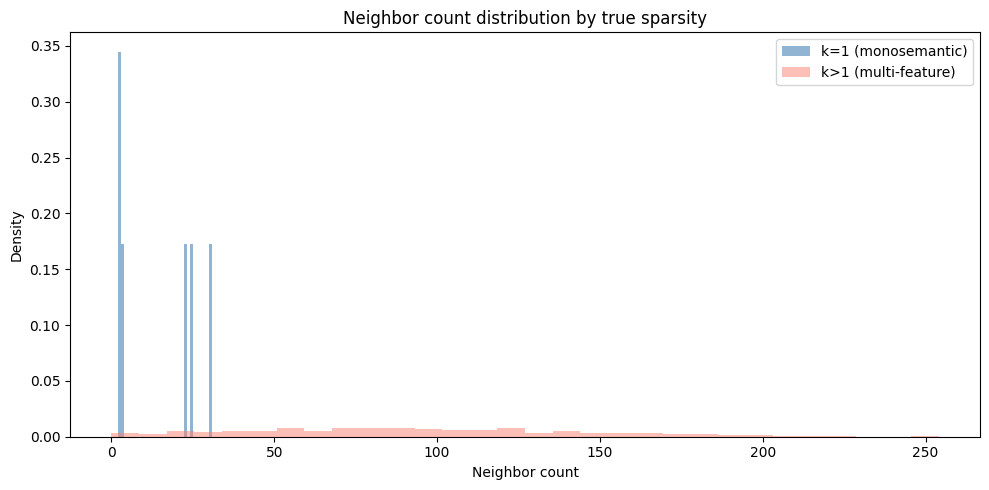

In [15]:
# Visualize: neighbor counts by sparsity level
fig, ax = plt.subplots(figsize=(10, 5))

if len(true_mono_indices) > 0:
    ax.hist(mono_nbr.numpy(), bins=30, alpha=0.6, label='k=1 (monosemantic)', density=True, color='steelblue')
    ax.hist(multi_nbr.numpy(), bins=30, alpha=0.5, label='k>1 (multi-feature)', density=True, color='salmon')
else:
    # Color by low-k vs high-k
    low_k = (nnz_oc <= 3)
    high_k = (nnz_oc > 6)
    if low_k.sum() > 0:
        ax.hist(nbr_counts_oc[low_k].float().numpy(), bins=30, alpha=0.6, label='k≤3 (sparse)', density=True, color='steelblue')
    if high_k.sum() > 0:
        ax.hist(nbr_counts_oc[high_k].float().numpy(), bins=30, alpha=0.5, label='k>6 (dense)', density=True, color='salmon')

ax.set_xlabel('Neighbor count')
ax.set_ylabel('Density')
ax.set_title('Neighbor count distribution by true sparsity')
ax.legend()
plt.tight_layout()
plt.show()

## The Alternative: Extract Everything, Filter by Spectral Gap

Since we can't identify monosemantic targets *before* extraction, we flip the approach:

1. **Extract from ALL unique neighbor-set representatives** (disable minimality filter)
2. For each extraction, record the singular value spectrum from the nullspace projection
3. **Use $\sigma_1 / \sigma_2$ (the spectral gap) to identify monosemantic extractions post-hoc**

The intuition: when a target's neighbors truly share one dominant feature, projecting them onto the nullspace of non-neighbors yields a rank-1 matrix — one huge singular value, everything else negligible. A large spectral gap $\sigma_1 / \sigma_2 \gg 1$ is the signature of monosemanticity.

Multi-feature targets will have more evenly distributed singular values (multiple significant directions in the projection).

In [16]:
# Extract from ALL unique neighbor-set representatives, recording spectral gaps
from src.extraction import cluster_by_neighbors

clusters_oc = cluster_by_neighbors(reps_oc, tau_oc)
print(f"Unique neighbor sets: {len(clusters_oc)}")

spectral_gaps = []
all_extracted = []
all_target_idx = []
all_singular_values = []
failed = 0

for neighbor_set, member_indices in clusters_oc.items():
    target_idx = member_indices[0]
    nbr_indices = torch.tensor(sorted(neighbor_set), dtype=torch.long)

    if len(nbr_indices) < 2:
        failed += 1
        continue

    try:
        nullspace = compute_nullspace(reps_oc, nbr_indices, epsilon=basis_oc.achieved_epsilon)
        if nullspace.shape[0] == 0:
            failed += 1
            continue

        neighbors = reps_oc[nbr_indices]
        projected = neighbors @ nullspace.T @ nullspace
        _, S, Vh = torch.linalg.svd(projected, full_matrices=False)

        feature = Vh[0]
        gap = (S[0] / S[1]).item() if len(S) > 1 and S[1] > 1e-10 else float('inf')

        all_extracted.append(feature)
        spectral_gaps.append(gap)
        all_target_idx.append(target_idx)
        all_singular_values.append(S[:5].tolist())
    except (ValueError, RuntimeError):
        failed += 1
        continue

all_extracted_t = torch.stack(all_extracted) if all_extracted else torch.empty(0, 50)
spectral_gaps_t = torch.tensor(spectral_gaps)

print(f"Successful extractions: {len(all_extracted)}")
print(f"Failed: {failed}")
if len(spectral_gaps_t) > 0:
    print(f"Spectral gap — min: {spectral_gaps_t.min():.2f}, median: {spectral_gaps_t.median():.2f}, max: {spectral_gaps_t.max():.2f}")
else:
    print("No successful extractions!")

Unique neighbor sets: 498


Successful extractions: 445
Failed: 53
Spectral gap — min: 1.01, median: 1.33, max: 17771322.00


In [17]:
if len(all_extracted) == 0:
    print("No successful extractions — skipping analysis")
    is_correct = torch.tensor([], dtype=torch.bool)
    correct_gaps = torch.tensor([])
    incorrect_gaps = torch.tensor([])
else:
    # Match each extraction to ground truth
    sims_to_gt = torch.abs(all_extracted_t @ basis_oc.features.T)  # (m, n)
    best_sim_per = sims_to_gt.max(dim=1).values
    is_correct = best_sim_per > 0.9
    print(f"Extractions matching a GT feature (|cos_sim| > 0.9): {is_correct.sum().item()} / {len(all_extracted)}")
    correct_gaps = spectral_gaps_t[is_correct]
    incorrect_gaps = spectral_gaps_t[~is_correct]
    print(f"\nSpectral gaps — correct:   median={correct_gaps.median():.2f}, mean={correct_gaps.mean():.2f}" if is_correct.sum() > 0 else "No correct extractions")
    print(f"Spectral gaps — incorrect: median={incorrect_gaps.median():.2f}, mean={incorrect_gaps.mean():.2f}" if (~is_correct).sum() > 0 else "All correct!")


Extractions matching a GT feature (|cos_sim| > 0.9): 115 / 445

Spectral gaps — correct:   median=10051291.00, mean=9096526.00
Spectral gaps — incorrect: median=1.29, mean=690695.00


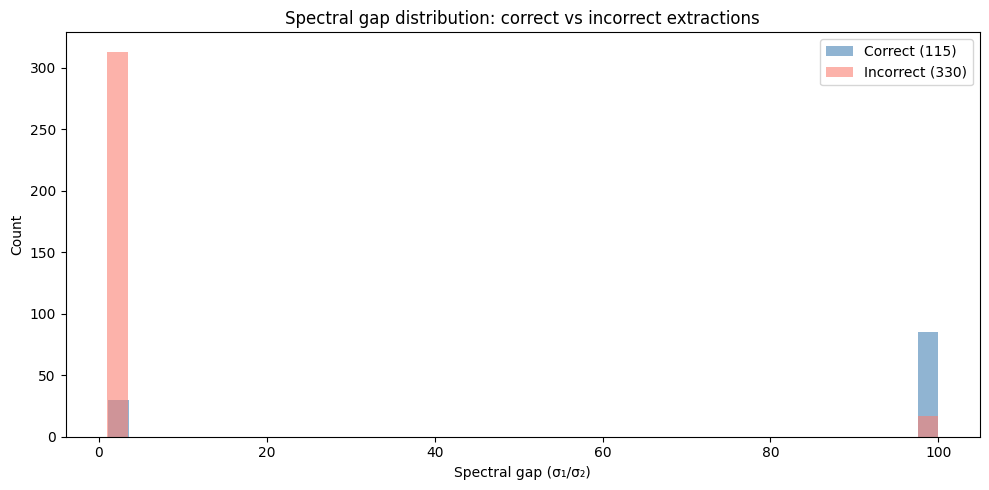

In [18]:
if len(spectral_gaps_t) == 0:
    print("No data to plot")
else:
    # Spectral gap histogram: correct vs incorrect
    fig, ax = plt.subplots(figsize=(10, 5))
    
    max_display = min(spectral_gaps_t.quantile(0.98).item() * 1.5, 100)
    
    if is_correct.sum() > 0:
        ax.hist(correct_gaps.clamp(max=max_display).numpy(), bins=40, alpha=0.6,
                label=f'Correct ({is_correct.sum().item()})', color='steelblue')
    if (~is_correct).sum() > 0:
        ax.hist(incorrect_gaps.clamp(max=max_display).numpy(), bins=40, alpha=0.6,
                label=f'Incorrect ({(~is_correct).sum().item()})', color='salmon')
    ax.set_xlabel('Spectral gap (σ₁/σ₂)')
    ax.set_ylabel('Count')
    ax.set_title('Spectral gap distribution: correct vs incorrect extractions')
    ax.legend()
    plt.tight_layout()
    plt.show()

## Precision/Recall at Different Spectral Gap Thresholds

We can sweep the spectral gap threshold to trade off precision (fraction of selected features that are correct) vs recall (fraction of ground-truth features recovered).

In [19]:
if len(all_extracted) == 0:
    print("No extractions — skipping threshold sweep")
    thresholds = []
    precisions = []
    recalls = []
    f1s = []
    unique_features_found = []
else:
    from src.extraction import _deduplicate_features
    thresholds = [1.0, 1.5, 2.0, 3.0, 5.0, 8.0, 10.0, 15.0, 20.0, 30.0, 50.0]
    n_gt = syn_config_oc.n
    print(f"{'Threshold':>10} {'Selected':>8} {'Deduped':>7} {'Matched':>7} {'Precision':>9} {'Recall':>7}")
    print("-" * 55)
    pr_precisions = []
    pr_recalls = []
    for thresh in thresholds:
        sel = spectral_gaps_t >= thresh
        if sel.sum() == 0:
            print(f"{thresh:>10.1f} {'—':>8}")
            pr_precisions.append(1.0)
            pr_recalls.append(0.0)
            continue
        sel_features = all_extracted_t[sel]
        if sel_features.shape[0] > 1:
            sel_features = _deduplicate_features(sel_features, threshold=0.95)
        matching, scores = match_features(sel_features, basis_oc.features, threshold=0.9)
        prec = len(matching) / sel_features.shape[0] if sel_features.shape[0] > 0 else 0
        rec = len(matching) / n_gt
        pr_precisions.append(prec)
        pr_recalls.append(rec)
        print(f"{thresh:>10.1f} {sel.sum().item():>8} {sel_features.shape[0]:>7} {len(matching):>7} {prec:>8.1%} {rec:>7.1%}")


 Threshold Selected Deduped Matched Precision  Recall
-------------------------------------------------------


       1.0      445     408      52    12.7%   86.7%
       1.5      112      83      49    59.0%   81.7%
       2.0      102      76      49    64.5%   81.7%


       3.0      102      76      49    64.5%   81.7%
       5.0      102      76      49    64.5%   81.7%
       8.0      102      76      49    64.5%   81.7%


      10.0      102      76      49    64.5%   81.7%
      15.0      102      76      49    64.5%   81.7%
      20.0      102      76      49    64.5%   81.7%


      30.0      102      76      49    64.5%   81.7%
      50.0      102      76      49    64.5%   81.7%


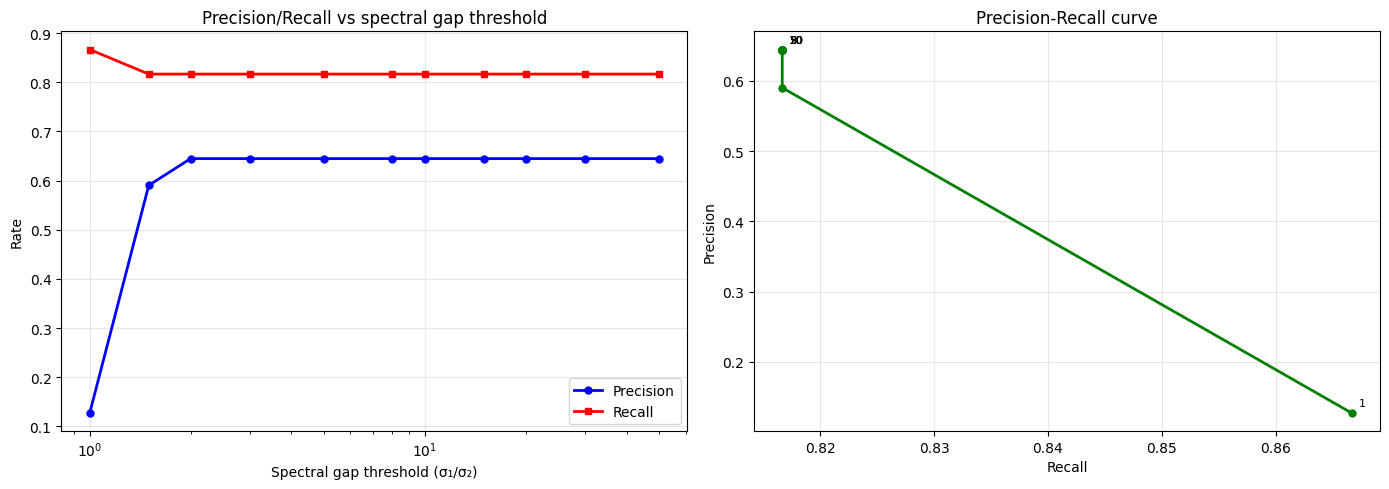

In [20]:
if not thresholds:
    print("No data to plot")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    # Precision and recall vs threshold
    ax = axes[0]
    ax.plot(thresholds, pr_precisions, 'b-o', markersize=5, linewidth=2, label='Precision')
    ax.plot(thresholds, pr_recalls, 'r-s', markersize=5, linewidth=2, label='Recall')
    ax.set_xlabel('Spectral gap threshold (σ₁/σ₂)')
    ax.set_ylabel('Rate')
    ax.set_title('Precision/Recall vs spectral gap threshold')
    ax.set_xscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)
    # PR curve
    ax = axes[1]
    ax.plot(pr_recalls, pr_precisions, 'g-o', markersize=5, linewidth=2)
    for i, t in enumerate(thresholds):
        if i % 2 == 0 and pr_recalls[i] > 0:
            ax.annotate(f'{t:.0f}', (pr_recalls[i], pr_precisions[i]),
                        textcoords='offset points', xytext=(5, 5), fontsize=8)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall curve')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## Multi-Feature Targets Can Yield Correct Features

An interesting finding: you don't *need* a truly monosemantic target (k=1) to extract a correct feature. If one feature in a multi-feature target dominates the neighbor set's shared direction, the SVD still picks it out. The spectral gap captures this.

In [21]:
# For each extraction, check the true sparsity of the target rep
target_true_k = nnz_oc[torch.tensor(all_target_idx)]

print(f"{'k':>4} | {'Total':>6} | {'Correct':>7} | {'Rate':>6} | {'Median gap':>10}")
print("-" * 50)

for k_val in sorted(set(target_true_k.tolist())):
    mask_k = (target_true_k == k_val)
    total = mask_k.sum().item()
    correct_k = (is_correct & mask_k).sum().item()
    gaps_k = spectral_gaps_t[mask_k]
    med_gap = gaps_k.median().item() if len(gaps_k) > 0 else 0
    print(f"{k_val:>4} | {total:>6} | {correct_k:>7} | {correct_k/total if total > 0 else 0:>5.1%} | {med_gap:>10.2f}")

   k |  Total | Correct |   Rate | Median gap
--------------------------------------------------
   1 |      2 |       2 | 100.0% | 7316216.00
   2 |     13 |      10 | 76.9% | 9326601.00
   3 |     32 |      24 | 75.0% | 8668105.00
   4 |     60 |      29 | 48.3% |       1.42
   5 |     74 |      23 | 31.1% |       1.32
   6 |     85 |      12 | 14.1% |       1.31
   7 |     69 |      12 | 17.4% |       1.28
   8 |     46 |       1 |  2.2% |       1.31
   9 |     33 |       2 |  6.1% |       1.28
  10 |     12 |       0 |  0.0% |       1.28
  11 |     10 |       0 |  0.0% |       1.29
  12 |      6 |       0 |  0.0% |       1.32
  13 |      2 |       0 |  0.0% |       1.32
  14 |      1 |       0 |  0.0% |       1.35


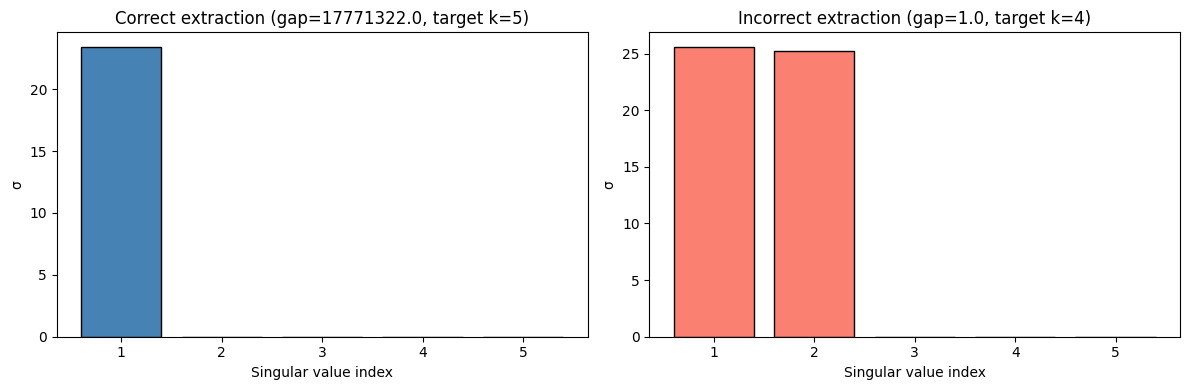

Left: one dominant singular value → monosemantic direction found
Right: multiple significant singular values → no single dominant feature


In [22]:
# Show a concrete example: singular value spectrum from a good vs bad extraction
# Find the extraction with the highest spectral gap that's correct
if is_correct.sum() > 0:
    correct_indices = torch.where(is_correct)[0]
    best_correct = correct_indices[spectral_gaps_t[correct_indices].argmax()].item()

    # Find a bad extraction (low gap, incorrect)
    if (~is_correct).sum() > 0:
        incorrect_indices = torch.where(~is_correct)[0]
        worst_incorrect = incorrect_indices[spectral_gaps_t[incorrect_indices].argmin()].item()
    else:
        worst_incorrect = None

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Good extraction
    sv_good = all_singular_values[best_correct]
    ax = axes[0]
    ax.bar(range(1, len(sv_good)+1), sv_good, color='steelblue', edgecolor='black')
    ax.set_xlabel('Singular value index')
    ax.set_ylabel('σ')
    k_good = nnz_oc[all_target_idx[best_correct]].item()
    ax.set_title(f'Correct extraction (gap={spectral_gaps[best_correct]:.1f}, target k={k_good})')

    # Bad extraction
    if worst_incorrect is not None:
        sv_bad = all_singular_values[worst_incorrect]
        ax = axes[1]
        ax.bar(range(1, len(sv_bad)+1), sv_bad, color='salmon', edgecolor='black')
        ax.set_xlabel('Singular value index')
        ax.set_ylabel('σ')
        k_bad = nnz_oc[all_target_idx[worst_incorrect]].item()
        ax.set_title(f'Incorrect extraction (gap={spectral_gaps[worst_incorrect]:.1f}, target k={k_bad})')

    plt.tight_layout()
    plt.show()
    
    print(f"Left: one dominant singular value → monosemantic direction found")
    print(f"Right: multiple significant singular values → no single dominant feature")

---
# Diagnostic: Monosemantic Feature Recovery and the ε̃ Threshold

We observed that monosemantic ($k=1$) representations often get **nullspace dimension 0** instead of 1 — the feature direction's singular value lands just above the $\tilde{\varepsilon}$ threshold. This section dissects *why*.

## 1. Single Monosemantic Feature Deep Dive (Orthogonal Case)

Generate fresh orthogonal data ($n = d = 64$) with variable sparsity ($k_{\min}=1$, $k_{\max}=3$) so we get a mix of monosemantic and polysemantic representations.

In [23]:
# Fresh orthogonal data for diagnostic
torch.manual_seed(123)

diag_syn_ortho = SyntheticConfig(
    d=64, n=64, k=3,
    num_representations=1000,
    sparsity_mode='variable',
    k_min=1,
)

diag_basis_ortho = generate_feature_basis(diag_syn_ortho.d, diag_syn_ortho.n)
diag_eps_ortho = diag_basis_ortho.achieved_epsilon
diag_reps_ortho, diag_coeffs_ortho = generate_representations(
    diag_basis_ortho.features, diag_syn_ortho, epsilon=diag_eps_ortho
)

# Identify k=1 representations
nnz_ortho = (diag_coeffs_ortho != 0).sum(dim=1)
mono_mask_ortho = nnz_ortho == 1
mono_indices_ortho = torch.where(mono_mask_ortho)[0]

print(f'Orthogonal case: d={diag_syn_ortho.d}, n={diag_syn_ortho.n}')
print(f'Achieved ε = {diag_eps_ortho:.6f}')
print(f'Total representations: {len(diag_reps_ortho)}')
print(f'k=1: {mono_mask_ortho.sum().item()}, k=2: {(nnz_ortho==2).sum().item()}, k=3: {(nnz_ortho==3).sum().item()}')
print(f'\nUsing first k=1 rep as target: index {mono_indices_ortho[0].item()}')

Orthogonal case: d=64, n=64
Achieved ε = 0.000000
Total representations: 1000
k=1: 344, k=2: 348, k=3: 308

Using first k=1 rep as target: index 0


In [24]:
# Resolve tau and pick a k=1 target
diag_ext_ortho = ExtractionConfig(tau=None, tau_margin=0.5, epsilon=0.0)
tau_ortho = resolve_tau(diag_ext_ortho, diag_syn_ortho, diag_eps_ortho)

tau_upper, tau_lower = compute_tau_bounds(
    k=diag_syn_ortho.k,
    epsilon=diag_eps_ortho,
    coef_min=compute_coef_min(diag_syn_ortho, diag_eps_ortho),
    coef_max=diag_syn_ortho.coef_max,
)
print(f'τ bounds: lower={tau_lower:.6f}, upper={tau_upper:.6f}')
print(f'Resolved τ = {tau_ortho:.6f}  (margin={diag_ext_ortho.tau_margin})')

target_idx = mono_indices_ortho[0].item()
target_rep = diag_reps_ortho[target_idx]

# Ground truth: which feature is active?
active_features = torch.where(diag_coeffs_ortho[target_idx] != 0)[0]
true_feature_idx = active_features[0].item()
print(f'\nTarget rep {target_idx}: active feature = {true_feature_idx}')
print(f'  coefficient = {diag_coeffs_ortho[target_idx, true_feature_idx]:.4f}')

τ bounds: lower=0.000000, upper=0.010000
Resolved τ = 0.005000  (margin=0.5)

Target rep 0: active feature = 36
  coefficient = -0.7799


In [25]:
# Neighbor analysis: algorithm vs ground truth
from src.extraction import find_neighbors

algo_neighbors = find_neighbors(diag_reps_ortho, target_idx, tau_ortho)

# Ground truth neighbors: all reps with nonzero coeff on the same feature
gt_neighbors = torch.where(diag_coeffs_ortho[:, true_feature_idx] != 0)[0]

algo_set = set(algo_neighbors.tolist())
gt_set = set(gt_neighbors.tolist())

true_positives = algo_set & gt_set
false_positives = algo_set - gt_set
false_negatives = gt_set - algo_set

precision = len(true_positives) / len(algo_set) if len(algo_set) > 0 else 0
recall = len(true_positives) / len(gt_set) if len(gt_set) > 0 else 0

print(f'Algorithm neighbors: {len(algo_set)}')
print(f'Ground truth neighbors (share feature {true_feature_idx}): {len(gt_set)}')
print(f'True positives: {len(true_positives)}')
print(f'False positives: {len(false_positives)}')
print(f'False negatives: {len(false_negatives)}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')

Algorithm neighbors: 28
Ground truth neighbors (share feature 36): 28
True positives: 28
False positives: 0
False negatives: 0
Precision: 1.000
Recall: 1.000


In [26]:
# SVD of mean-centered non-neighbors: WITH vs WITHOUT mean centering
neighbor_set = set(algo_neighbors.tolist())
non_neighbor_indices = [i for i in range(len(diag_reps_ortho)) if i not in neighbor_set]
non_neighbors = diag_reps_ortho[non_neighbor_indices]
n_neg = len(non_neighbor_indices)

# Without mean centering
_, S_raw, Vh_raw = torch.linalg.svd(non_neighbors, full_matrices=True)

# With mean centering (what the algorithm does)
mean_neg = non_neighbors.mean(dim=0, keepdim=True)
non_neighbors_centered = non_neighbors - mean_neg
_, S_centered, Vh_centered = torch.linalg.svd(non_neighbors_centered, full_matrices=True)

# Compute ε̃ threshold
d = diag_syn_ortho.d
norms = torch.norm(diag_reps_ortho, dim=1)
rms_norm = torch.sqrt(torch.mean(norms**2))
if diag_eps_ortho > 0:
    scaled_eps = (n_neg**0.5) * rms_norm * diag_eps_ortho
else:
    scaled_eps = 1e-6  # numerical floor for orthogonal case

# Pad S to length d
full_S_raw = torch.zeros(d)
full_S_raw[:len(S_raw)] = S_raw[:d]
full_S_centered = torch.zeros(d)
full_S_centered[:len(S_centered)] = S_centered[:d]

n_below_raw = (full_S_raw < scaled_eps).sum().item()
n_below_centered = (full_S_centered < scaled_eps).sum().item()

print(f'ε̃ threshold = {scaled_eps:.6f}  (ε={diag_eps_ortho:.6f}, n_neg={n_neg}, RMS‖r‖={rms_norm:.4f})')
print(f'SVs below ε̃ (raw):      {n_below_raw}')
print(f'SVs below ε̃ (centered): {n_below_centered}')
print(f'\nSmallest 5 SVs (raw):      {full_S_raw[-5:].tolist()}')
print(f'Smallest 5 SVs (centered): {full_S_centered[-5:].tolist()}')

ε̃ threshold = 0.000001  (ε=0.000000, n_neg=972, RMS‖r‖=0.8613)
SVs below ε̃ (raw):      0
SVs below ε̃ (centered): 0

Smallest 5 SVs (raw):      [2.51295804977417, 2.467625141143799, 2.2215969562530518, 2.193181276321411, 1.3603128081740579e-06]
Smallest 5 SVs (centered): [2.5095579624176025, 2.4666543006896973, 2.2184414863586426, 2.19173526763916, 1.7654905377639807e-06]


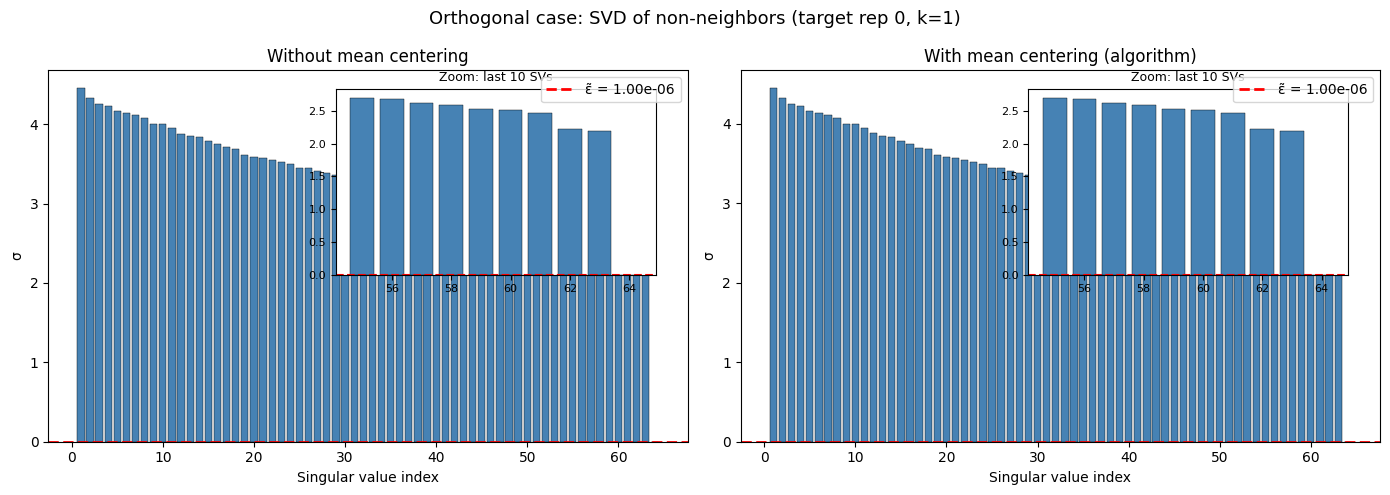

Nullspace dimension (SVs < ε̃): 0
⚠ Nullspace is EMPTY — algorithm cannot extract this feature!
  Smallest SV = 1.765491e-06 vs ε̃ = 1.000000e-06


In [27]:
# Plot: ALL singular values with ε̃ threshold line
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, S_vals, title in [
    (axes[0], full_S_raw, 'Without mean centering'),
    (axes[1], full_S_centered, 'With mean centering (algorithm)'),
]:
    indices = np.arange(1, d + 1)
    colors = ['salmon' if s < scaled_eps else 'steelblue' for s in S_vals]
    ax.bar(indices, S_vals.numpy(), color=colors, edgecolor='black', linewidth=0.3)
    ax.axhline(y=scaled_eps, color='red', linestyle='--', linewidth=2,
               label=f'ε̃ = {scaled_eps:.2e}')
    ax.set_xlabel('Singular value index')
    ax.set_ylabel('σ')
    ax.set_title(title)
    ax.legend()
    # Inset: zoom on the smallest SVs
    ax_inset = ax.inset_axes([0.45, 0.45, 0.5, 0.5])
    zoom_range = slice(max(0, d-10), d)
    zoom_indices = indices[zoom_range]
    zoom_S = S_vals[zoom_range].numpy()
    zoom_colors = colors[zoom_range]
    ax_inset.bar(zoom_indices, zoom_S, color=zoom_colors, edgecolor='black', linewidth=0.3)
    ax_inset.axhline(y=scaled_eps, color='red', linestyle='--', linewidth=1.5)
    ax_inset.set_title('Zoom: last 10 SVs', fontsize=9)
    ax_inset.tick_params(labelsize=8)

plt.suptitle(f'Orthogonal case: SVD of non-neighbors (target rep {target_idx}, k=1)', fontsize=13)
plt.tight_layout()
plt.show()

print(f'Nullspace dimension (SVs < ε̃): {n_below_centered}')
if n_below_centered == 0:
    print('⚠ Nullspace is EMPTY — algorithm cannot extract this feature!')
    print(f'  Smallest SV = {full_S_centered[-1]:.6e} vs ε̃ = {scaled_eps:.6e}')
elif n_below_centered == 1:
    print('✓ Nullspace dim = 1 — feature should be recoverable')
else:
    print(f'Nullspace dim = {n_below_centered} — multiple directions below threshold')

## 2. Overcomplete Case ($n > d$, $\varepsilon > 0$)

Same analysis but with $n = 96 > d = 64$, so $\varepsilon > 0$ and the threshold is the actual $\tilde{\varepsilon}$ formula.

In [28]:
# Fresh overcomplete data
torch.manual_seed(123)

diag_syn_oc = SyntheticConfig(
    d=64, n=96, k=3,
    num_representations=1000,
    sparsity_mode='variable',
    k_min=1,
)

diag_basis_oc = generate_feature_basis(diag_syn_oc.d, diag_syn_oc.n)
diag_eps_oc = diag_basis_oc.achieved_epsilon
diag_reps_oc, diag_coeffs_oc = generate_representations(
    diag_basis_oc.features, diag_syn_oc, epsilon=diag_eps_oc
)

nnz_oc_diag = (diag_coeffs_oc != 0).sum(dim=1)
mono_mask_oc = nnz_oc_diag == 1
mono_indices_oc = torch.where(mono_mask_oc)[0]

print(f'Overcomplete case: d={diag_syn_oc.d}, n={diag_syn_oc.n}')
print(f'Achieved ε = {diag_eps_oc:.6f}  (Welch bound = {diag_basis_oc.welch_bound:.6f})')
print(f'k=1: {mono_mask_oc.sum().item()}, k=2: {(nnz_oc_diag==2).sum().item()}, k=3: {(nnz_oc_diag==3).sum().item()}')

Overcomplete case: d=64, n=96
Achieved ε = 0.079894  (Welch bound = 0.072548)
k=1: 343, k=2: 308, k=3: 349


In [29]:
# Single k=1 deep dive — overcomplete
diag_ext_oc = ExtractionConfig(tau=None, tau_margin=0.5, epsilon=diag_eps_oc)
tau_oc = resolve_tau(diag_ext_oc, diag_syn_oc, diag_eps_oc)

tau_upper_oc, tau_lower_oc = compute_tau_bounds(
    k=diag_syn_oc.k,
    epsilon=diag_eps_oc,
    coef_min=compute_coef_min(diag_syn_oc, diag_eps_oc),
    coef_max=diag_syn_oc.coef_max,
)
print(f'τ bounds: lower={tau_lower_oc:.6f}, upper={tau_upper_oc:.6f}')
print(f'Resolved τ = {tau_oc:.6f}')

target_idx_oc = mono_indices_oc[0].item()
active_features_oc = torch.where(diag_coeffs_oc[target_idx_oc] != 0)[0]
true_feat_oc = active_features_oc[0].item()

# Neighbor analysis
algo_nb_oc = find_neighbors(diag_reps_oc, target_idx_oc, tau_oc)
gt_nb_oc = torch.where(diag_coeffs_oc[:, true_feat_oc] != 0)[0]

algo_set_oc = set(algo_nb_oc.tolist())
gt_set_oc = set(gt_nb_oc.tolist())
tp_oc = algo_set_oc & gt_set_oc
fp_oc = algo_set_oc - gt_set_oc
fn_oc = gt_set_oc - algo_set_oc

prec_oc = len(tp_oc) / len(algo_set_oc) if algo_set_oc else 0
rec_oc = len(tp_oc) / len(gt_set_oc) if gt_set_oc else 0

print(f'\nTarget rep {target_idx_oc} (feature {true_feat_oc}):')
print(f'  Algo neighbors: {len(algo_set_oc)}, GT neighbors: {len(gt_set_oc)}')
print(f'  Precision: {prec_oc:.3f}, Recall: {rec_oc:.3f}')

τ bounds: lower=0.719046, upper=5.744745
Resolved τ = 3.231895

Target rep 0 (feature 67):
  Algo neighbors: 0, GT neighbors: 22
  Precision: 0.000, Recall: 0.000


In [30]:
# SVD analysis — overcomplete case
nb_set_oc = set(algo_nb_oc.tolist())
non_nb_idx_oc = [i for i in range(len(diag_reps_oc)) if i not in nb_set_oc]
non_nb_oc = diag_reps_oc[non_nb_idx_oc]
n_neg_oc = len(non_nb_idx_oc)
d_oc = diag_syn_oc.d

# Without mean centering
_, S_raw_oc, _ = torch.linalg.svd(non_nb_oc, full_matrices=True)

# With mean centering
mean_neg_oc = non_nb_oc.mean(dim=0, keepdim=True)
_, S_cent_oc, _ = torch.linalg.svd(non_nb_oc - mean_neg_oc, full_matrices=True)

# ε̃ — this time with real epsilon
norms_oc = torch.norm(diag_reps_oc, dim=1)
rms_oc = torch.sqrt(torch.mean(norms_oc**2))
scaled_eps_oc = (n_neg_oc**0.5) * rms_oc * diag_eps_oc

full_S_raw_oc = torch.zeros(d_oc)
full_S_raw_oc[:min(len(S_raw_oc), d_oc)] = S_raw_oc[:d_oc]
full_S_cent_oc = torch.zeros(d_oc)
full_S_cent_oc[:min(len(S_cent_oc), d_oc)] = S_cent_oc[:d_oc]

n_below_oc = (full_S_cent_oc < scaled_eps_oc).sum().item()

print(f'ε̃ = {scaled_eps_oc:.4f}  (ε={diag_eps_oc:.6f}, √n_neg={n_neg_oc**0.5:.1f}, RMS‖r‖={rms_oc:.4f})')
print(f'SVs below ε̃ (centered): {n_below_oc}')
print(f'Smallest 5 SVs (centered): {[f"{v:.4f}" for v in full_S_cent_oc[-5:].tolist()]}')

ε̃ = 6.2112  (ε=0.079894, √n_neg=31.6, RMS‖r‖=2.4584)
SVs below ε̃ (centered): 0
Smallest 5 SVs (centered): ['7.1805', '7.0549', '6.9880', '6.9057', '6.4241']


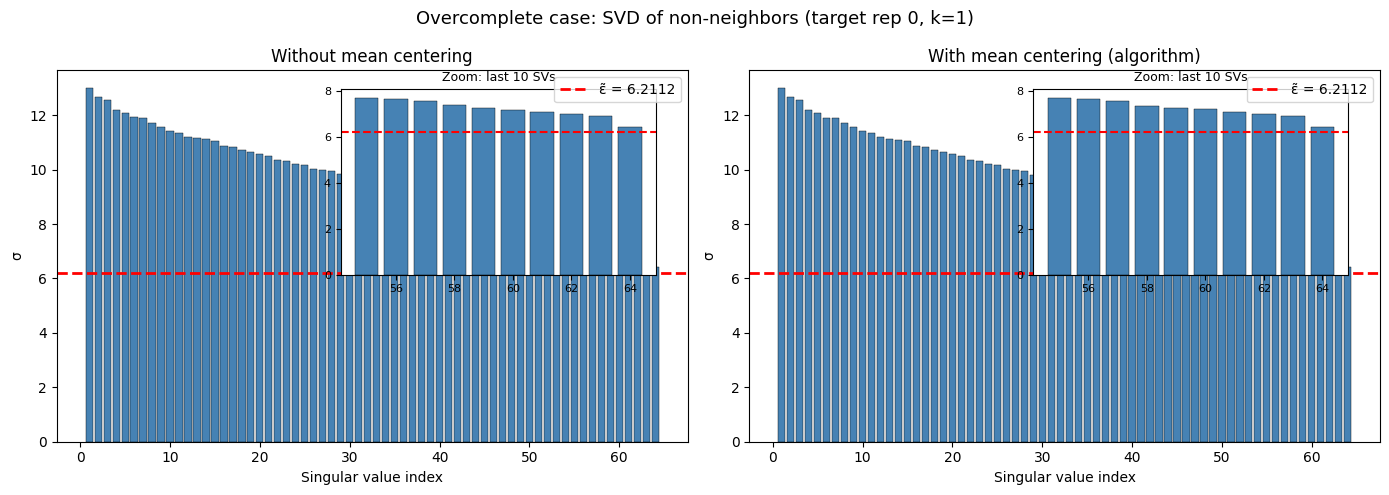

Nullspace dimension: 0
⚠ Nullspace EMPTY — smallest SV = 6.4241e+00 vs ε̃ = 6.2112e+00


In [31]:
# Plot: overcomplete SV spectrum
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, S_vals, title, eps_line in [
    (axes[0], full_S_raw_oc, 'Without mean centering', scaled_eps_oc),
    (axes[1], full_S_cent_oc, 'With mean centering (algorithm)', scaled_eps_oc),
]:
    indices = np.arange(1, d_oc + 1)
    colors = ['salmon' if s < eps_line else 'steelblue' for s in S_vals]
    ax.bar(indices, S_vals.numpy(), color=colors, edgecolor='black', linewidth=0.3)
    ax.axhline(y=eps_line, color='red', linestyle='--', linewidth=2,
               label=f'ε̃ = {eps_line:.4f}')
    ax.set_xlabel('Singular value index')
    ax.set_ylabel('σ')
    ax.set_title(title)
    ax.legend()
    # Zoom inset
    ax_inset = ax.inset_axes([0.45, 0.45, 0.5, 0.5])
    zoom_range = slice(max(0, d_oc-10), d_oc)
    zoom_indices = indices[zoom_range]
    zoom_S = S_vals[zoom_range].numpy()
    zoom_colors = colors[zoom_range]
    ax_inset.bar(zoom_indices, zoom_S, color=zoom_colors, edgecolor='black', linewidth=0.3)
    ax_inset.axhline(y=eps_line, color='red', linestyle='--', linewidth=1.5)
    ax_inset.set_title('Zoom: last 10 SVs', fontsize=9)
    ax_inset.tick_params(labelsize=8)

plt.suptitle(f'Overcomplete case: SVD of non-neighbors (target rep {target_idx_oc}, k=1)', fontsize=13)
plt.tight_layout()
plt.show()

print(f'Nullspace dimension: {n_below_oc}')
if n_below_oc == 0:
    print(f'⚠ Nullspace EMPTY — smallest SV = {full_S_cent_oc[-1]:.4e} vs ε̃ = {scaled_eps_oc:.4e}')
elif n_below_oc == 1:
    print('✓ Nullspace dim = 1')
else:
    print(f'Nullspace dim = {n_below_oc}')

## 3. Aggregate: All $k=1$ Features

For every monosemantic representation, compute the nullspace dimension. Histogram of "SVs below $\tilde{\varepsilon}$" tells us how often the algorithm can even *see* the feature.

In [32]:
# Aggregate analysis for ALL k=1 targets — both cases
def analyze_all_mono(reps, coeffs, syn_config, eps, label):
    ext_cfg = ExtractionConfig(tau=None, tau_margin=0.5, epsilon=eps)
    tau = resolve_tau(ext_cfg, syn_config, eps)
    d = syn_config.d
    nnz = (coeffs != 0).sum(dim=1)
    mono_idx = torch.where(nnz == 1)[0]

    norms = torch.norm(reps, dim=1)
    rms = torch.sqrt(torch.mean(norms**2))

    nullspace_dims = []
    smallest_svs = []
    spectral_gaps = []

    for idx in mono_idx:
        idx = idx.item()
        nb = find_neighbors(reps, idx, tau)
        nb_set = set(nb.tolist())
        non_nb_idx = [i for i in range(len(reps)) if i not in nb_set]

        if len(non_nb_idx) < 2:
            continue

        non_nb = reps[non_nb_idx]
        n_neg = len(non_nb_idx)
        mean_neg = non_nb.mean(dim=0, keepdim=True)
        centered = non_nb - mean_neg

        _, S, _ = torch.linalg.svd(centered, full_matrices=True)
        full_S = torch.zeros(d)
        full_S[:min(len(S), d)] = S[:d]

        if eps > 0:
            threshold = (n_neg**0.5) * rms * eps
        else:
            threshold = 1e-6

        n_below = (full_S < threshold).sum().item()
        nullspace_dims.append(n_below)
        smallest_svs.append(full_S[-1].item())

        # Spectral gap: ratio of last two distinct SVs
        if n_below >= 1 and n_below < d:
            gap = full_S[d - n_below - 1] / (full_S[d - n_below] + 1e-12)
        else:
            gap = 0.0
        spectral_gaps.append(gap)

    return mono_idx, nullspace_dims, smallest_svs, spectral_gaps

mono_idx_o, ns_dims_o, small_svs_o, gaps_o = analyze_all_mono(
    diag_reps_ortho, diag_coeffs_ortho, diag_syn_ortho, diag_eps_ortho, 'Orthogonal')
mono_idx_c, ns_dims_c, small_svs_c, gaps_c = analyze_all_mono(
    diag_reps_oc, diag_coeffs_oc, diag_syn_oc, diag_eps_oc, 'Overcomplete')

print(f'Orthogonal: {len(ns_dims_o)} k=1 targets analyzed')
print(f'Overcomplete: {len(ns_dims_c)} k=1 targets analyzed')

Orthogonal: 344 k=1 targets analyzed
Overcomplete: 343 k=1 targets analyzed


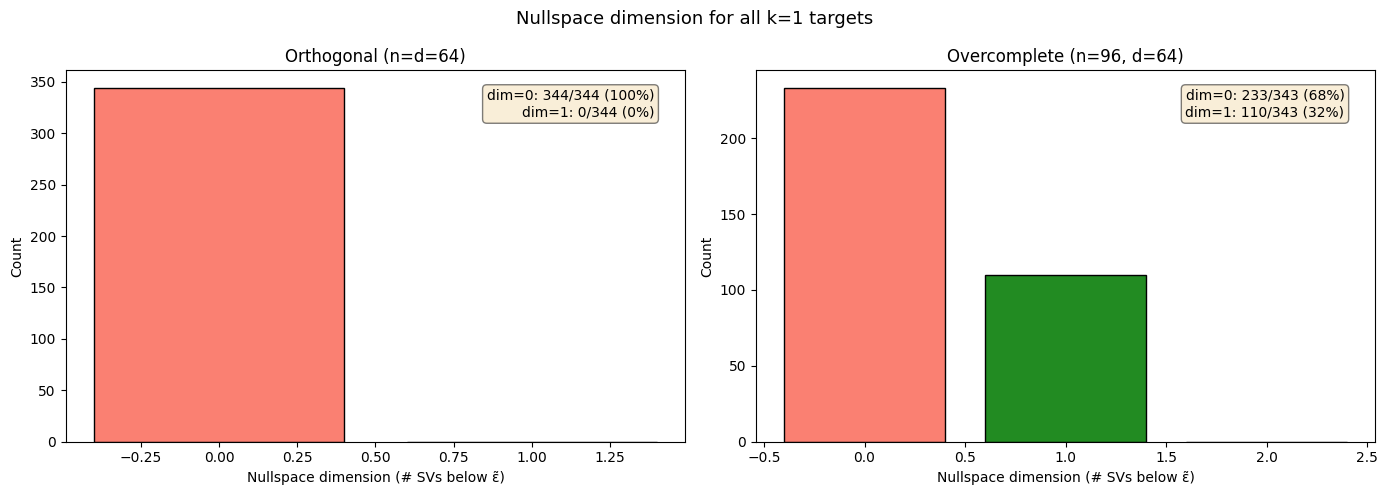

In [33]:
# Histogram of nullspace dimensions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, dims, label in [
    (axes[0], ns_dims_o, 'Orthogonal (n=d=64)'),
    (axes[1], ns_dims_c, 'Overcomplete (n=96, d=64)'),
]:
    if len(dims) == 0:
        ax.text(0.5, 0.5, 'No k=1 targets', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(label)
        continue
    max_dim = max(dims) + 1
    bins = np.arange(-0.5, max_dim + 1.5, 1)
    counts, _, patches = ax.hist(dims, bins=bins, color='steelblue', edgecolor='black', rwidth=0.8)
    # Highlight dim=0 (failure) and dim=1 (ideal)
    for p, left_edge in zip(patches, bins):
        center = left_edge + 0.5
        if abs(center - 0) < 0.1:
            p.set_facecolor('salmon')
        elif abs(center - 1) < 0.1:
            p.set_facecolor('forestgreen')
    ax.set_xlabel('Nullspace dimension (# SVs below ε̃)')
    ax.set_ylabel('Count')
    ax.set_title(label)
    dim0 = dims.count(0)
    dim1 = dims.count(1)
    total = len(dims)
    ax.annotate(f'dim=0: {dim0}/{total} ({100*dim0/total:.0f}%)\n'
                f'dim=1: {dim1}/{total} ({100*dim1/total:.0f}%)',
                xy=(0.95, 0.95), xycoords='axes fraction',
                ha='right', va='top', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Nullspace dimension for all k=1 targets', fontsize=13)
plt.tight_layout()
plt.show()

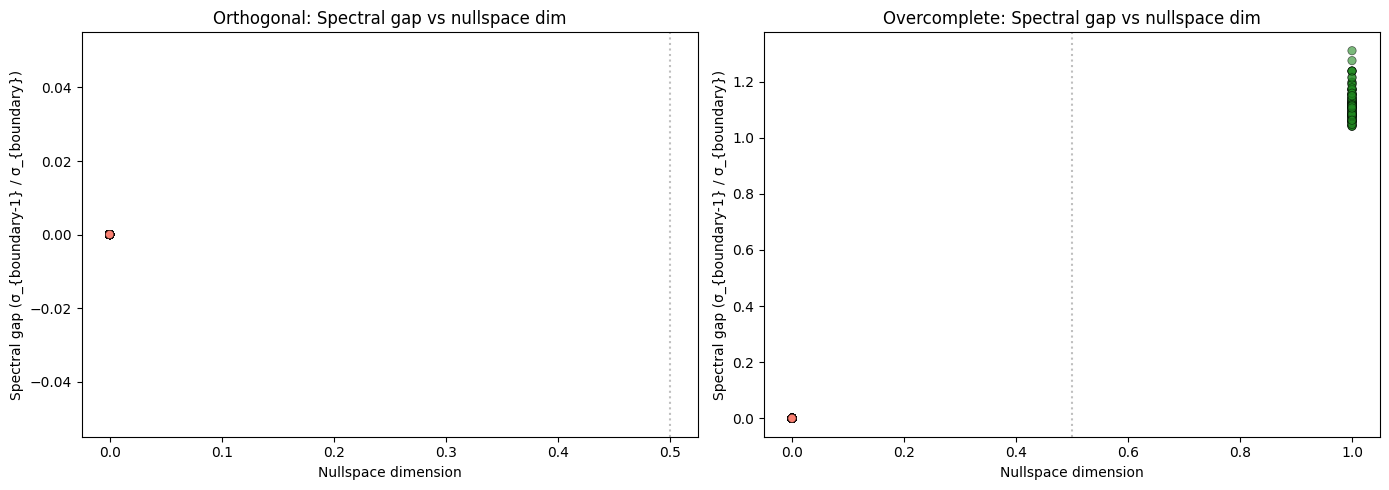

In [34]:
# Spectral gap as discriminator vs nullspace dim
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, dims, gaps, label in [
    (axes[0], ns_dims_o, gaps_o, 'Orthogonal'),
    (axes[1], ns_dims_c, gaps_c, 'Overcomplete'),
]:
    if len(dims) == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(label)
        continue
    colors = ['forestgreen' if d >= 1 else 'salmon' for d in dims]
    ax.scatter(dims, gaps, c=colors, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax.set_xlabel('Nullspace dimension')
    ax.set_ylabel('Spectral gap (σ_{boundary-1} / σ_{boundary})')
    ax.set_title(f'{label}: Spectral gap vs nullspace dim')
    ax.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

## 4. Neighbor Quality Statistics

Precision and recall of the $\tau$-based neighbor selection for all $k=1$ targets. This tells us whether the problem is in neighbor selection or in the nullspace computation.

In [35]:
# Neighbor precision/recall for all k=1 targets
def neighbor_quality(reps, coeffs, syn_config, eps, label):
    ext_cfg = ExtractionConfig(tau=None, tau_margin=0.5, epsilon=eps)
    tau = resolve_tau(ext_cfg, syn_config, eps)
    nnz = (coeffs != 0).sum(dim=1)
    mono_idx = torch.where(nnz == 1)[0]

    precisions = []
    recalls = []
    n_algo = []
    n_gt = []

    for idx in mono_idx:
        idx = idx.item()
        active = torch.where(coeffs[idx] != 0)[0]
        feat = active[0].item()

        algo_nb = set(find_neighbors(reps, idx, tau).tolist())
        gt_nb = set(torch.where(coeffs[:, feat] != 0)[0].tolist())

        tp = len(algo_nb & gt_nb)
        p = tp / len(algo_nb) if algo_nb else 0
        r = tp / len(gt_nb) if gt_nb else 0

        precisions.append(p)
        recalls.append(r)
        n_algo.append(len(algo_nb))
        n_gt.append(len(gt_nb))

    return precisions, recalls, n_algo, n_gt

prec_o, rec_o, na_o, ng_o = neighbor_quality(
    diag_reps_ortho, diag_coeffs_ortho, diag_syn_ortho, diag_eps_ortho, 'Orthogonal')
prec_c, rec_c, na_c, ng_c = neighbor_quality(
    diag_reps_oc, diag_coeffs_oc, diag_syn_oc, diag_eps_oc, 'Overcomplete')

for label, prec, rec in [('Orthogonal', prec_o, rec_o), ('Overcomplete', prec_c, rec_c)]:
    if len(prec) == 0:
        print(f'{label}: no k=1 targets')
        continue
    print(f'{label} ({len(prec)} targets):')
    print(f'  Precision: mean={np.mean(prec):.3f}, median={np.median(prec):.3f}, min={np.min(prec):.3f}')
    print(f'  Recall:    mean={np.mean(rec):.3f}, median={np.median(rec):.3f}, min={np.min(rec):.3f}')
    print(f'  Algo neighbors: mean={np.mean(na_o):.0f}, GT neighbors: mean={np.mean(ng_o):.0f}')

Orthogonal (344 targets):
  Precision: mean=1.000, median=1.000, min=1.000
  Recall:    mean=1.000, median=1.000, min=1.000
  Algo neighbors: mean=32, GT neighbors: mean=32
Overcomplete (343 targets):
  Precision: mean=0.741, median=1.000, min=0.000
  Recall:    mean=0.331, median=0.296, min=0.000
  Algo neighbors: mean=32, GT neighbors: mean=32


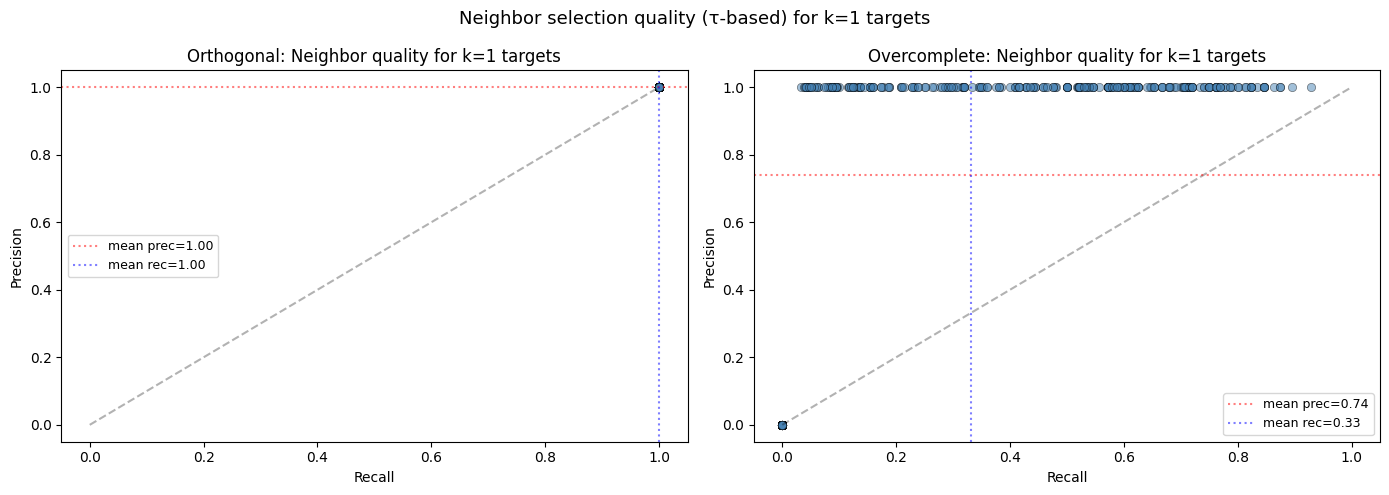

In [36]:
# Scatter: precision vs recall for k=1 targets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, prec, rec, label in [
    (axes[0], prec_o, rec_o, 'Orthogonal'),
    (axes[1], prec_c, rec_c, 'Overcomplete'),
]:
    if len(prec) == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(label)
        continue
    ax.scatter(rec, prec, alpha=0.5, edgecolors='black', linewidth=0.5, color='steelblue')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title(f'{label}: Neighbor quality for k=1 targets')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax.axhline(y=np.mean(prec), color='red', linestyle=':', alpha=0.5, label=f'mean prec={np.mean(prec):.2f}')
    ax.axvline(x=np.mean(rec), color='blue', linestyle=':', alpha=0.5, label=f'mean rec={np.mean(rec):.2f}')
    ax.legend(fontsize=9)

plt.suptitle('Neighbor selection quality (τ-based) for k=1 targets', fontsize=13)
plt.tight_layout()
plt.show()

### Interpretation

If precision is high but nullspace dim = 0, the problem is in the $\tilde{\varepsilon}$ threshold — the feature direction's singular value is just barely above the cutoff. If precision is low, contaminated neighbors are the root cause.

For the **orthogonal case** ($\varepsilon = 0$), the threshold is the numerical floor $10^{-6}$, which is essentially zero. Any SV that *should* be zero will be below it, so the issue is whether the feature direction's SV is *truly* zero in the non-neighbor subspace — it shouldn't be, because the feature is absent from non-neighbors by construction.

For the **overcomplete case** ($\varepsilon > 0$), the threshold $\tilde{\varepsilon} = \sqrt{n_{\text{neg}}} \cdot \text{RMS}(\|r\|) \cdot \varepsilon$ can be large enough to swallow the feature direction's SV, especially when $n_{\text{neg}}$ is large and $\varepsilon$ is non-trivial.

---
# Summary

## Experiment 1: Cosine Similarity → Dot Product

**Problem:** Cosine similarity normalizes by $\|r_i\|\|r_j\|$, destroying magnitude information. When $\varepsilon > 0$, small-coefficient shared features become indistinguishable from cross-feature interference after normalization.

**Fix:** Switch to raw dot product. The new $\tau$ bounds are:
$$\tau_{\text{upper}} = c_{\min}^2 \quad \text{(min sharing signal)}$$
$$\tau_{\text{lower}} = k^2 c_{\max}^2 \varepsilon \quad \text{(max non-sharing noise)}$$

Separable when $c_{\min}^2 > k^2 c_{\max}^2 \varepsilon$. The bounds directly reflect the physics of the data generation.

## Experiment 2: Post-Hoc Spectral Gap Filtering

**Problem:** The minimality filter (select targets with fewest neighbors) has 0% recall in the overcomplete case. Monosemantic reps have *high* neighbor counts because their single feature is shared widely. Multi-feature reps with unusual combinations have *low* counts.

**Fix:** Extract from *all* unique neighbor-set representatives, then filter post-hoc using the spectral gap $\sigma_1 / \sigma_2$ from the nullspace-projected SVD. A large gap indicates a single dominant feature direction was found — the hallmark of a monosemantic extraction.

**Key finding:** Even multi-feature targets can yield correct features if one feature dominates the neighbor set's shared direction. The spectral gap captures this automatically.